# 🛰️ Satellite Image Segmentation Project
Multi-band (12 channels) semantic segmentation using PyTorch

## Step 1: Imports

In [1]:
pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 48.5 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn.functional as F
from tqdm import tqdm

## Step 2: Paths and device

In [3]:
BASE_PATH = '/kaggle/input/datasets/alaa5sayed/satellite-dataset/data'

IMAGES_DIR = os.path.join(BASE_PATH, 'images')
LABELS_DIR = os.path.join(BASE_PATH, 'labels')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Images: ', len(os.listdir(IMAGES_DIR)))
print('Labels: ', len(os.listdir(LABELS_DIR)))

Images:  306
Labels:  456


## Step 3: Data Inspection

In [4]:
sample_image_path = os.listdir(IMAGES_DIR)[0]
sample_mask_path = os.listdir(LABELS_DIR)[0]

with rasterio.open(os.path.join(IMAGES_DIR, sample_image_path)) as src:
    image = src.read()

mask = np.array(Image.open(os.path.join(LABELS_DIR, sample_mask_path)))

print('Image shape: ', image.shape)
print('Mask shape: ', mask.shape)
print('Mask unique values: ', np.unique(mask))

Image shape:  (12, 128, 128)
Mask shape:  (128, 128)
Mask unique values:  [0 1]


/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:367: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.026150028631418208..1.0].


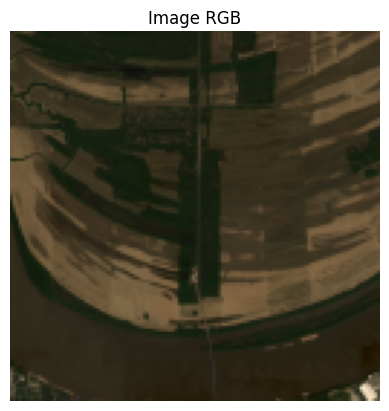

In [5]:
rgb = np.stack([image[3], image[2], image[1]], axis=-1)
rgb = rgb / rgb.max()

plt.imshow(rgb)
plt.title('Image RGB')
plt.axis('off')
plt.show()

In [6]:
labels = os.listdir(LABELS_DIR)
print(labels[:20])

['38_68.png', '121_142.png', '173.png', '248.png', '94.png', '40_277.png', '18_42.png', '236.png', '85_117.png', '48.png', '23_251.png', '227.png', '97_130.png', '238.png', '61.png', '222.png', '108_236.png', '278.png', '62_187.png', '303.png']


## Step 4: Data Matching & Cleaning

In [7]:
images = [f.replace(".tif", "") for f in os.listdir(IMAGES_DIR)]
labels = os.listdir(LABELS_DIR)

valid_labels = [f for f in labels if "_" not in f]

matched = [f"{img}.png" for img in images if f"{img}.png" in valid_labels]

print("Matched pairs:", len(matched))

Matched pairs: 306


## Step 5: Visualization

In [8]:
sample_image_path = os.listdir(IMAGES_DIR)[0]
sample_image = os.path.join(IMAGES_DIR, sample_image_path)

print(sample_image)
print(os.path.exists(sample_image))

/kaggle/input/datasets/alaa5sayed/satellite-dataset/data/images/274.tif
True


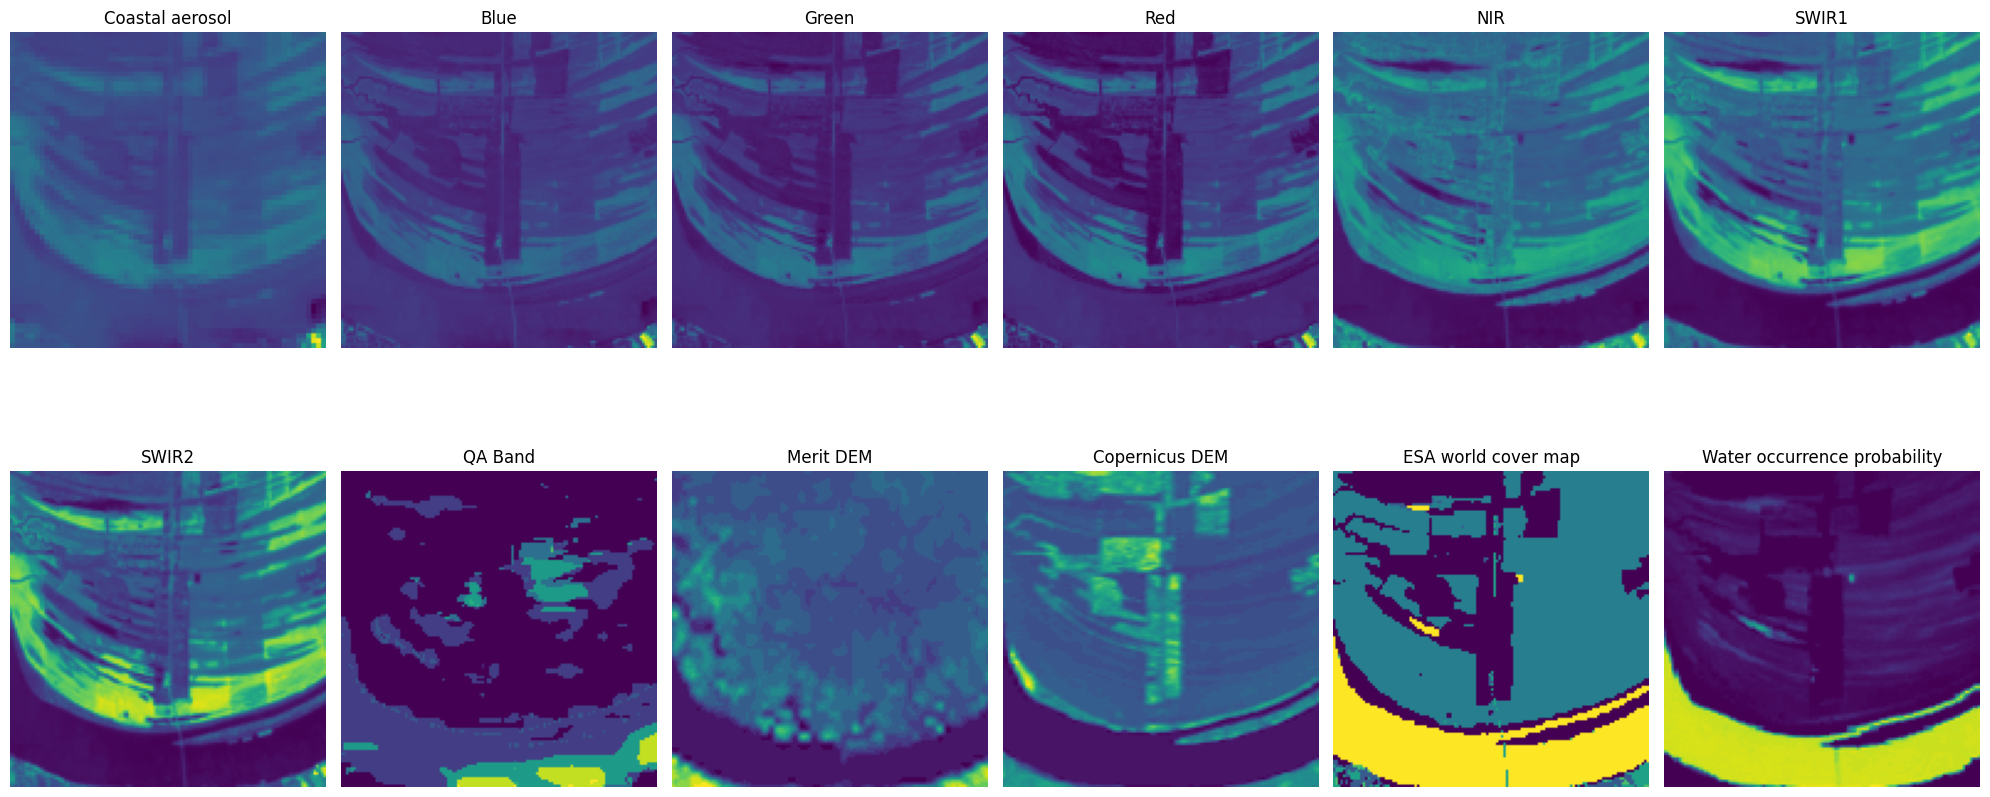

In [9]:
def visualize_bands(image_path):
    with rasterio.open(image_path) as src:
        img = src.read()

    band_names = [
        "Coastal aerosol", "Blue", "Green", "Red", "NIR", "SWIR1", 
        "SWIR2", "QA Band", "Merit DEM", "Copernicus DEM",
        "ESA world cover map", "Water occurrence probability"
    ]

    plt.figure(figsize=(20, 10))
    for i in range(12):
        plt.subplot(2, 6, i+1)
        plt.imshow(img[i], cmap='viridis')
        plt.title(band_names[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

if os.path.exists(sample_image):
    visualize_bands(sample_image)
else:
    print('Path Error')

## Step 6: Train / Validation Split

In [10]:
train_files, temp_files = train_test_split(
    matched,
    test_size=0.4,
    random_state=42,
    shuffle=True
)

print('Train files: ', len(train_files))
print('Validation files: ', len(temp_files))

Train files:  183
Validation files:  123


In [11]:
val_files, test_files = train_test_split(
    temp_files,
    test_size=0.5,
    random_state=42,
    shuffle=True
)

print('Validation files: ', len(val_files))
print('Test files: ', len(test_files))

Validation files:  61
Test files:  62


## Step 7:Dataset class

In [12]:
class SatelliteDataset(Dataset):
    def __init__(self, files, images_dir, labels_dir, transform=None):
        self.files = files
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_name = self.files[idx]
        img_path = os.path.join(self.images_dir, file_name.replace('.png', '.tif'))
        mask_path = os.path.join(self.labels_dir, file_name)

        with rasterio.open(img_path) as src:
            img = src.read().astype(np.float32)  # shape = (12, 128, 128)

        # Normalization
        for i in range(img.shape[0]):
            band_min = img[i].min()
            band_max = img[i].max()
            if band_max > band_min:
                img[i] = (img[i] - band_min) / (band_max - band_min)

        mask = np.array(Image.open(mask_path))
        mask = (mask > 0).astype(np.float32)  # binary mask

        img = np.transpose(img, (1, 2, 0))  # (H, W, C)
        mask = mask.astype(np.float32)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']

        img = torch.from_numpy(np.transpose(img, (2, 0, 1))).float()
        mask = torch.from_numpy(mask).unsqueeze(0).float()  # (1, H, W)

        return img, mask

## Step 8: Albumentations transforms

In [13]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.5), # exclude mask
], additional_targets={'mask': 'mask'}
)

val_transform = A.Compose([], additional_targets={'mask': 'mask'})

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [14]:
BATCH_SIZE = 4

train_dataset = SatelliteDataset(train_files, IMAGES_DIR, LABELS_DIR, transform=train_transform)
val_dataset = SatelliteDataset(val_files, IMAGES_DIR, LABELS_DIR, transform=val_transform)
test_dataset = SatelliteDataset(test_files, IMAGES_DIR, LABELS_DIR, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Step 9: U-Net Model

In [15]:
class UNet(nn.Module):
    def __init__(self, in_channels=12, out_channels=1):
        super(UNet, self).__init__()

        def contract_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = contract_block(in_channels, 32)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = contract_block(32, 64)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = contract_block(64, 128)

        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = contract_block(128, 64)

        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = contract_block(64, 32)

        self.out = nn.Conv2d(32, out_channels, 1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        # Bottleneck
        b = self.bottleneck(p2)

        # Decoder
        u2 = self.up2(b)
        d2 = self.dec2(torch.cat([u2, e2], dim=1))

        u1 = self.up1(d2)
        d1 = self.dec1(torch.cat([u1, e1], dim=1))

        out = torch.sigmoid(self.out(d1))
        # out = self.out(d1)
        return out

model = UNet().to(DEVICE)

## Loss, optimizer, metrics

In [16]:
LEARNING_RATE = 1e-3
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [17]:
class MixedLoss(nn.Module):
    def __init__(self, dice_weight=0.5):
        super().__init__()
        self.dice_weight = dice_weight
        self.bce = nn.BCELoss()

    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        pred = pred.view(-1)
        target = target.view(-1)
        inter = (pred * target).sum()
        dice_loss = 1 - (2.*inter + 1e-6) / (pred.sum() + target.sum() + 1e-6)
        return (bce_loss * (1 - self.dice_weight)) + (dice_loss * self.dice_weight)

In [18]:
criterion = MixedLoss(dice_weight=0.5)

In [19]:
def get_metrics(y_pred, y_true):
    y_pred = (y_pred > 0.5).float()
    intersection = (y_pred * y_true).sum()
    union = (y_pred + y_true).sum() - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)

    tp = (y_pred * y_true).sum()
    fp = (y_pred * (1 - y_true)).sum()
    fn = ((1 - y_pred) * y_true).sum()

    precision = tp / (tp + fp + 1e-7)
    recall = tp / (tp + fn + 1e-7)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-7)

    return iou.item(), precision.item(), recall.item(), f1.item()

## Step 10: Training

In [20]:
EPOCHS = 100
best_val_iou = 0

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_iou = 0
    train_precision = 0
    train_recall = 0
    train_f1 = 0

    for imgs, masks in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)
        iou, precision, recall, f1 = get_metrics(outputs, masks)
        train_iou += iou * imgs.size(0)
        train_precision += precision * imgs.size(0)
        train_recall += recall * imgs.size(0)
        train_f1 += f1 * imgs.size(0)

    # Validation
    model.eval()
    val_loss = 0
    val_iou = 0
    val_precision = 0
    val_recall = 0
    val_f1 = 0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * imgs.size(0)
            iou, precision, recall, f1 = get_metrics(outputs, masks)
            val_iou += iou * imgs.size(0)
            val_precision += precision * imgs.size(0)
            val_recall += recall * imgs.size(0)
            val_f1 += f1 * imgs.size(0)

    n_train = len(train_loader.dataset)
    n_val = len(val_loader.dataset)
    print(f"Epoch [{epoch+1}/{EPOCHS}]")
    print(f"Train Loss: {train_loss/n_train:.4f} | IoU: {train_iou/n_train:.4f} | Precision: {train_precision/n_train:.4f} | Recall: {train_recall/n_train:.4f} | F1: {train_f1/n_train:.4f}")
    print(f"Val   Loss: {val_loss/n_val:.4f} | IoU: {val_iou/n_val:.4f} | Precision: {val_precision/n_val:.4f} | Recall: {val_recall/n_val:.4f} | F1: {val_f1/n_val:.4f}")
    print("-"*80)

    # Save the best model
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(model.state_dict(), 'satellite_model.pth')
        print('🔥 Best model saved!')

Training Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:367: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)
Training Epoch 1: 100%|██████████| 46/46 [00:08<00:00,  5.73it/s]


Epoch [1/100]
Train Loss: 0.5620 | IoU: 0.2539 | Precision: 0.6225 | Recall: 0.2664 | F1: 0.3550
Val   Loss: 0.5071 | IoU: 0.2931 | Precision: 0.7112 | Recall: 0.3420 | F1: 0.4301
--------------------------------------------------------------------------------
🔥 Best model saved!


Training Epoch 2: 100%|██████████| 46/46 [00:01<00:00, 24.13it/s]


Epoch [2/100]
Train Loss: 1.0129 | IoU: 0.4371 | Precision: 0.7874 | Recall: 0.4995 | F1: 0.5791
Val   Loss: 0.4648 | IoU: 0.5233 | Precision: 0.6749 | Recall: 0.7115 | F1: 0.6590
--------------------------------------------------------------------------------
🔥 Best model saved!


Training Epoch 3: 100%|██████████| 46/46 [00:01<00:00, 24.47it/s]


Epoch [3/100]
Train Loss: 1.5069 | IoU: 0.4508 | Precision: 0.7997 | Recall: 0.5360 | F1: 0.5978
Val   Loss: 0.4090 | IoU: 0.5544 | Precision: 0.8348 | Recall: 0.6303 | F1: 0.6961
--------------------------------------------------------------------------------
🔥 Best model saved!


Training Epoch 4: 100%|██████████| 46/46 [00:01<00:00, 25.27it/s]


Epoch [4/100]
Train Loss: 0.9185 | IoU: 0.5059 | Precision: 0.7862 | Recall: 0.5955 | F1: 0.6449
Val   Loss: 0.3268 | IoU: 0.6026 | Precision: 0.9109 | Recall: 0.6424 | F1: 0.7378
--------------------------------------------------------------------------------
🔥 Best model saved!


Training Epoch 5: 100%|██████████| 46/46 [00:01<00:00, 24.62it/s]


Epoch [5/100]
Train Loss: 0.3383 | IoU: 0.5665 | Precision: 0.8708 | Recall: 0.6270 | F1: 0.7055
Val   Loss: 0.3171 | IoU: 0.6195 | Precision: 0.8842 | Recall: 0.6678 | F1: 0.7501
--------------------------------------------------------------------------------
🔥 Best model saved!


Training Epoch 6: 100%|██████████| 46/46 [00:01<00:00, 25.02it/s]


Epoch [6/100]
Train Loss: 0.3328 | IoU: 0.5521 | Precision: 0.8427 | Recall: 0.6232 | F1: 0.6928
Val   Loss: 0.3236 | IoU: 0.5939 | Precision: 0.8590 | Recall: 0.6704 | F1: 0.7295
--------------------------------------------------------------------------------


Training Epoch 7: 100%|██████████| 46/46 [00:01<00:00, 24.69it/s]


Epoch [7/100]
Train Loss: 0.3286 | IoU: 0.5511 | Precision: 0.8490 | Recall: 0.6091 | F1: 0.6884
Val   Loss: 0.3269 | IoU: 0.6266 | Precision: 0.8675 | Recall: 0.6860 | F1: 0.7548
--------------------------------------------------------------------------------
🔥 Best model saved!


Training Epoch 8: 100%|██████████| 46/46 [00:01<00:00, 24.29it/s]


Epoch [8/100]
Train Loss: 0.3245 | IoU: 0.5795 | Precision: 0.8666 | Recall: 0.6388 | F1: 0.7175
Val   Loss: 0.3170 | IoU: 0.6319 | Precision: 0.9135 | Recall: 0.6706 | F1: 0.7585
--------------------------------------------------------------------------------
🔥 Best model saved!


Training Epoch 9: 100%|██████████| 46/46 [00:01<00:00, 25.31it/s]


Epoch [9/100]
Train Loss: 0.3213 | IoU: 0.5733 | Precision: 0.8625 | Recall: 0.6358 | F1: 0.7072
Val   Loss: 0.3032 | IoU: 0.6409 | Precision: 0.8956 | Recall: 0.6926 | F1: 0.7649
--------------------------------------------------------------------------------
🔥 Best model saved!


Training Epoch 10: 100%|██████████| 46/46 [00:01<00:00, 25.27it/s]


Epoch [10/100]
Train Loss: 0.3262 | IoU: 0.5565 | Precision: 0.8557 | Recall: 0.6166 | F1: 0.6916
Val   Loss: 0.2829 | IoU: 0.6524 | Precision: 0.8871 | Recall: 0.7071 | F1: 0.7721
--------------------------------------------------------------------------------
🔥 Best model saved!


Training Epoch 11: 100%|██████████| 46/46 [00:01<00:00, 24.70it/s]


Epoch [11/100]
Train Loss: 0.3100 | IoU: 0.5812 | Precision: 0.8447 | Recall: 0.6550 | F1: 0.7098
Val   Loss: 0.3015 | IoU: 0.6388 | Precision: 0.9152 | Recall: 0.6766 | F1: 0.7631
--------------------------------------------------------------------------------


Training Epoch 12: 100%|██████████| 46/46 [00:01<00:00, 25.08it/s]


Epoch [12/100]
Train Loss: 0.3021 | IoU: 0.6067 | Precision: 0.8731 | Recall: 0.6682 | F1: 0.7412
Val   Loss: 0.2845 | IoU: 0.6588 | Precision: 0.8549 | Recall: 0.7313 | F1: 0.7752
--------------------------------------------------------------------------------
🔥 Best model saved!


Training Epoch 13: 100%|██████████| 46/46 [00:01<00:00, 25.30it/s]


Epoch [13/100]
Train Loss: 0.3050 | IoU: 0.5948 | Precision: 0.8505 | Recall: 0.6649 | F1: 0.7264
Val   Loss: 0.2851 | IoU: 0.6488 | Precision: 0.9004 | Recall: 0.6962 | F1: 0.7704
--------------------------------------------------------------------------------


Training Epoch 14: 100%|██████████| 46/46 [00:01<00:00, 24.10it/s]


Epoch [14/100]
Train Loss: 0.3165 | IoU: 0.6101 | Precision: 0.8482 | Recall: 0.6824 | F1: 0.7432
Val   Loss: 0.3097 | IoU: 0.6411 | Precision: 0.9191 | Recall: 0.6777 | F1: 0.7644
--------------------------------------------------------------------------------


Training Epoch 15: 100%|██████████| 46/46 [00:01<00:00, 23.39it/s]


Epoch [15/100]
Train Loss: 0.3017 | IoU: 0.5858 | Precision: 0.8753 | Recall: 0.6376 | F1: 0.7178
Val   Loss: 0.2797 | IoU: 0.6545 | Precision: 0.8524 | Recall: 0.7315 | F1: 0.7740
--------------------------------------------------------------------------------


Training Epoch 16: 100%|██████████| 46/46 [00:01<00:00, 26.46it/s]


Epoch [16/100]
Train Loss: 0.3075 | IoU: 0.5809 | Precision: 0.8313 | Recall: 0.6534 | F1: 0.7098
Val   Loss: 0.3330 | IoU: 0.6416 | Precision: 0.9163 | Recall: 0.6787 | F1: 0.7646
--------------------------------------------------------------------------------


Training Epoch 17: 100%|██████████| 46/46 [00:01<00:00, 25.79it/s]


Epoch [17/100]
Train Loss: 0.3087 | IoU: 0.5850 | Precision: 0.8532 | Recall: 0.6577 | F1: 0.7229
Val   Loss: 0.3600 | IoU: 0.6276 | Precision: 0.9300 | Recall: 0.6563 | F1: 0.7547
--------------------------------------------------------------------------------


Training Epoch 18: 100%|██████████| 46/46 [00:01<00:00, 27.14it/s]


Epoch [18/100]
Train Loss: 0.2981 | IoU: 0.5956 | Precision: 0.8521 | Recall: 0.6646 | F1: 0.7282
Val   Loss: 0.2770 | IoU: 0.6602 | Precision: 0.8718 | Recall: 0.7228 | F1: 0.7788
--------------------------------------------------------------------------------
🔥 Best model saved!


Training Epoch 19: 100%|██████████| 46/46 [00:01<00:00, 26.44it/s]


Epoch [19/100]
Train Loss: 0.2815 | IoU: 0.6232 | Precision: 0.8557 | Recall: 0.6949 | F1: 0.7521
Val   Loss: 0.2733 | IoU: 0.6658 | Precision: 0.8382 | Recall: 0.7501 | F1: 0.7832
--------------------------------------------------------------------------------
🔥 Best model saved!


Training Epoch 20: 100%|██████████| 46/46 [00:01<00:00, 26.50it/s]


Epoch [20/100]
Train Loss: 0.3047 | IoU: 0.5912 | Precision: 0.8510 | Recall: 0.6527 | F1: 0.7271
Val   Loss: 0.2828 | IoU: 0.6649 | Precision: 0.8424 | Recall: 0.7479 | F1: 0.7821
--------------------------------------------------------------------------------


Training Epoch 21: 100%|██████████| 46/46 [00:01<00:00, 23.56it/s]


Epoch [21/100]
Train Loss: 0.2973 | IoU: 0.5862 | Precision: 0.8251 | Recall: 0.6608 | F1: 0.7131
Val   Loss: 0.2889 | IoU: 0.6550 | Precision: 0.8688 | Recall: 0.7140 | F1: 0.7743
--------------------------------------------------------------------------------


Training Epoch 22: 100%|██████████| 46/46 [00:01<00:00, 26.71it/s]


Epoch [22/100]
Train Loss: 0.2741 | IoU: 0.6209 | Precision: 0.8696 | Recall: 0.6850 | F1: 0.7557
Val   Loss: 0.3185 | IoU: 0.6456 | Precision: 0.9051 | Recall: 0.6881 | F1: 0.7673
--------------------------------------------------------------------------------


Training Epoch 23: 100%|██████████| 46/46 [00:01<00:00, 25.97it/s]


Epoch [23/100]
Train Loss: 0.2786 | IoU: 0.6183 | Precision: 0.8379 | Recall: 0.6918 | F1: 0.7432
Val   Loss: 0.2769 | IoU: 0.6584 | Precision: 0.8579 | Recall: 0.7261 | F1: 0.7756
--------------------------------------------------------------------------------


Training Epoch 24: 100%|██████████| 46/46 [00:01<00:00, 26.67it/s]


Epoch [24/100]
Train Loss: 0.3021 | IoU: 0.5930 | Precision: 0.8368 | Recall: 0.6690 | F1: 0.7206
Val   Loss: 0.2727 | IoU: 0.6646 | Precision: 0.8211 | Recall: 0.7631 | F1: 0.7814
--------------------------------------------------------------------------------


Training Epoch 25: 100%|██████████| 46/46 [00:01<00:00, 27.14it/s]


Epoch [25/100]
Train Loss: 0.2973 | IoU: 0.6082 | Precision: 0.8500 | Recall: 0.6855 | F1: 0.7401
Val   Loss: 0.2725 | IoU: 0.6709 | Precision: 0.8288 | Recall: 0.7658 | F1: 0.7864
--------------------------------------------------------------------------------
🔥 Best model saved!


Training Epoch 26: 100%|██████████| 46/46 [00:01<00:00, 26.54it/s]


Epoch [26/100]
Train Loss: 0.2901 | IoU: 0.6141 | Precision: 0.8487 | Recall: 0.6884 | F1: 0.7457
Val   Loss: 0.2750 | IoU: 0.6647 | Precision: 0.8507 | Recall: 0.7409 | F1: 0.7817
--------------------------------------------------------------------------------


Training Epoch 27: 100%|██████████| 46/46 [00:01<00:00, 27.25it/s]


Epoch [27/100]
Train Loss: 0.2855 | IoU: 0.6155 | Precision: 0.8276 | Recall: 0.7051 | F1: 0.7448
Val   Loss: 0.2869 | IoU: 0.6584 | Precision: 0.8602 | Recall: 0.7254 | F1: 0.7755
--------------------------------------------------------------------------------


Training Epoch 28: 100%|██████████| 46/46 [00:01<00:00, 26.92it/s]


Epoch [28/100]
Train Loss: 0.2751 | IoU: 0.6253 | Precision: 0.8385 | Recall: 0.7070 | F1: 0.7520
Val   Loss: 0.3018 | IoU: 0.6544 | Precision: 0.8752 | Recall: 0.7115 | F1: 0.7731
--------------------------------------------------------------------------------


Training Epoch 29: 100%|██████████| 46/46 [00:01<00:00, 25.29it/s]


Epoch [29/100]
Train Loss: 0.2923 | IoU: 0.5987 | Precision: 0.8258 | Recall: 0.6896 | F1: 0.7325
Val   Loss: 0.2813 | IoU: 0.6563 | Precision: 0.8714 | Recall: 0.7167 | F1: 0.7753
--------------------------------------------------------------------------------


Training Epoch 30: 100%|██████████| 46/46 [00:01<00:00, 26.83it/s]


Epoch [30/100]
Train Loss: 0.2889 | IoU: 0.6072 | Precision: 0.8289 | Recall: 0.6948 | F1: 0.7403
Val   Loss: 0.3032 | IoU: 0.6469 | Precision: 0.8960 | Recall: 0.6902 | F1: 0.7673
--------------------------------------------------------------------------------


Training Epoch 31: 100%|██████████| 46/46 [00:01<00:00, 26.98it/s]


Epoch [31/100]
Train Loss: 0.2743 | IoU: 0.6089 | Precision: 0.8334 | Recall: 0.6923 | F1: 0.7387
Val   Loss: 0.2635 | IoU: 0.6717 | Precision: 0.8628 | Recall: 0.7415 | F1: 0.7879
--------------------------------------------------------------------------------
🔥 Best model saved!


Training Epoch 32: 100%|██████████| 46/46 [00:01<00:00, 26.93it/s]


Epoch [32/100]
Train Loss: 0.3008 | IoU: 0.5914 | Precision: 0.8409 | Recall: 0.6680 | F1: 0.7270
Val   Loss: 0.2690 | IoU: 0.6683 | Precision: 0.8455 | Recall: 0.7480 | F1: 0.7839
--------------------------------------------------------------------------------


Training Epoch 33: 100%|██████████| 46/46 [00:01<00:00, 26.64it/s]


Epoch [33/100]
Train Loss: 0.2690 | IoU: 0.6290 | Precision: 0.8491 | Recall: 0.7006 | F1: 0.7536
Val   Loss: 0.2734 | IoU: 0.6617 | Precision: 0.8815 | Recall: 0.7172 | F1: 0.7796
--------------------------------------------------------------------------------


Training Epoch 34: 100%|██████████| 46/46 [00:01<00:00, 26.96it/s]


Epoch [34/100]
Train Loss: 0.2839 | IoU: 0.6065 | Precision: 0.8269 | Recall: 0.6920 | F1: 0.7366
Val   Loss: 0.2647 | IoU: 0.6680 | Precision: 0.8670 | Recall: 0.7330 | F1: 0.7841
--------------------------------------------------------------------------------


Training Epoch 35: 100%|██████████| 46/46 [00:01<00:00, 26.45it/s]


Epoch [35/100]
Train Loss: 0.2884 | IoU: 0.5921 | Precision: 0.8210 | Recall: 0.6848 | F1: 0.7203
Val   Loss: 0.2757 | IoU: 0.6610 | Precision: 0.8678 | Recall: 0.7241 | F1: 0.7782
--------------------------------------------------------------------------------


Training Epoch 36: 100%|██████████| 46/46 [00:01<00:00, 26.94it/s]


Epoch [36/100]
Train Loss: 0.2748 | IoU: 0.6221 | Precision: 0.8576 | Recall: 0.6911 | F1: 0.7529
Val   Loss: 0.2689 | IoU: 0.6704 | Precision: 0.8333 | Recall: 0.7604 | F1: 0.7855
--------------------------------------------------------------------------------


Training Epoch 37: 100%|██████████| 46/46 [00:01<00:00, 26.46it/s]


Epoch [37/100]
Train Loss: 0.2738 | IoU: 0.6190 | Precision: 0.8482 | Recall: 0.6959 | F1: 0.7488
Val   Loss: 0.2799 | IoU: 0.6684 | Precision: 0.7784 | Recall: 0.8069 | F1: 0.7813
--------------------------------------------------------------------------------


Training Epoch 38: 100%|██████████| 46/46 [00:01<00:00, 26.36it/s]


Epoch [38/100]
Train Loss: 0.2859 | IoU: 0.5983 | Precision: 0.8141 | Recall: 0.7040 | F1: 0.7276
Val   Loss: 0.3040 | IoU: 0.6569 | Precision: 0.8737 | Recall: 0.7153 | F1: 0.7764
--------------------------------------------------------------------------------


Training Epoch 39: 100%|██████████| 46/46 [00:01<00:00, 27.77it/s]


Epoch [39/100]
Train Loss: 0.2572 | IoU: 0.6371 | Precision: 0.8615 | Recall: 0.7112 | F1: 0.7667
Val   Loss: 0.2793 | IoU: 0.6668 | Precision: 0.8719 | Recall: 0.7286 | F1: 0.7835
--------------------------------------------------------------------------------


Training Epoch 40: 100%|██████████| 46/46 [00:01<00:00, 25.99it/s]


Epoch [40/100]
Train Loss: 0.2764 | IoU: 0.5983 | Precision: 0.8100 | Recall: 0.6818 | F1: 0.7232
Val   Loss: 0.2743 | IoU: 0.6648 | Precision: 0.8580 | Recall: 0.7340 | F1: 0.7812
--------------------------------------------------------------------------------


Training Epoch 41: 100%|██████████| 46/46 [00:01<00:00, 26.84it/s]


Epoch [41/100]
Train Loss: 0.2636 | IoU: 0.6359 | Precision: 0.8328 | Recall: 0.7317 | F1: 0.7643
Val   Loss: 0.2575 | IoU: 0.6750 | Precision: 0.8462 | Recall: 0.7559 | F1: 0.7888
--------------------------------------------------------------------------------
🔥 Best model saved!


Training Epoch 42: 100%|██████████| 46/46 [00:01<00:00, 26.83it/s]


Epoch [42/100]
Train Loss: 0.2761 | IoU: 0.6309 | Precision: 0.8323 | Recall: 0.7155 | F1: 0.7560
Val   Loss: 0.2830 | IoU: 0.6639 | Precision: 0.7756 | Recall: 0.8053 | F1: 0.7797
--------------------------------------------------------------------------------


Training Epoch 43: 100%|██████████| 46/46 [00:01<00:00, 26.33it/s]


Epoch [43/100]
Train Loss: 0.3733 | IoU: 0.5588 | Precision: 0.8313 | Recall: 0.6490 | F1: 0.6941
Val   Loss: 0.2946 | IoU: 0.6451 | Precision: 0.8644 | Recall: 0.7115 | F1: 0.7679
--------------------------------------------------------------------------------


Training Epoch 44: 100%|██████████| 46/46 [00:01<00:00, 26.44it/s]


Epoch [44/100]
Train Loss: 0.3840 | IoU: 0.5769 | Precision: 0.8357 | Recall: 0.6600 | F1: 0.7178
Val   Loss: 0.2999 | IoU: 0.6402 | Precision: 0.9011 | Recall: 0.6875 | F1: 0.7663
--------------------------------------------------------------------------------


Training Epoch 45: 100%|██████████| 46/46 [00:01<00:00, 26.22it/s]


Epoch [45/100]
Train Loss: 0.3031 | IoU: 0.5897 | Precision: 0.8465 | Recall: 0.6521 | F1: 0.7225
Val   Loss: 0.2964 | IoU: 0.6420 | Precision: 0.8712 | Recall: 0.7071 | F1: 0.7673
--------------------------------------------------------------------------------


Training Epoch 46: 100%|██████████| 46/46 [00:01<00:00, 27.11it/s]


Epoch [46/100]
Train Loss: 0.2916 | IoU: 0.6191 | Precision: 0.8426 | Recall: 0.7064 | F1: 0.7510
Val   Loss: 0.2973 | IoU: 0.6499 | Precision: 0.8790 | Recall: 0.7089 | F1: 0.7725
--------------------------------------------------------------------------------


Training Epoch 47: 100%|██████████| 46/46 [00:01<00:00, 27.28it/s]


Epoch [47/100]
Train Loss: 0.2914 | IoU: 0.5868 | Precision: 0.8244 | Recall: 0.6661 | F1: 0.7212
Val   Loss: 0.2889 | IoU: 0.6554 | Precision: 0.8796 | Recall: 0.7138 | F1: 0.7761
--------------------------------------------------------------------------------


Training Epoch 48: 100%|██████████| 46/46 [00:01<00:00, 26.77it/s]


Epoch [48/100]
Train Loss: 0.2796 | IoU: 0.6054 | Precision: 0.8233 | Recall: 0.6900 | F1: 0.7337
Val   Loss: 0.2813 | IoU: 0.6594 | Precision: 0.8621 | Recall: 0.7288 | F1: 0.7795
--------------------------------------------------------------------------------


Training Epoch 49: 100%|██████████| 46/46 [00:01<00:00, 27.06it/s]


Epoch [49/100]
Train Loss: 0.2800 | IoU: 0.6264 | Precision: 0.8668 | Recall: 0.7007 | F1: 0.7528
Val   Loss: 0.2752 | IoU: 0.6601 | Precision: 0.8564 | Recall: 0.7350 | F1: 0.7795
--------------------------------------------------------------------------------


Training Epoch 50: 100%|██████████| 46/46 [00:01<00:00, 27.08it/s]


Epoch [50/100]
Train Loss: 0.2859 | IoU: 0.5948 | Precision: 0.8267 | Recall: 0.6709 | F1: 0.7255
Val   Loss: 0.3059 | IoU: 0.6225 | Precision: 0.9099 | Recall: 0.6561 | F1: 0.7502
--------------------------------------------------------------------------------


Training Epoch 51: 100%|██████████| 46/46 [00:01<00:00, 27.07it/s]


Epoch [51/100]
Train Loss: 0.2685 | IoU: 0.6168 | Precision: 0.8676 | Recall: 0.6783 | F1: 0.7427
Val   Loss: 0.3074 | IoU: 0.6523 | Precision: 0.8885 | Recall: 0.7033 | F1: 0.7737
--------------------------------------------------------------------------------


Training Epoch 52: 100%|██████████| 46/46 [00:01<00:00, 25.83it/s]


Epoch [52/100]
Train Loss: 0.2779 | IoU: 0.6047 | Precision: 0.8217 | Recall: 0.6859 | F1: 0.7325
Val   Loss: 0.2724 | IoU: 0.6648 | Precision: 0.8744 | Recall: 0.7266 | F1: 0.7832
--------------------------------------------------------------------------------


Training Epoch 53: 100%|██████████| 46/46 [00:01<00:00, 27.44it/s]


Epoch [53/100]
Train Loss: 0.2823 | IoU: 0.5880 | Precision: 0.8116 | Recall: 0.6809 | F1: 0.7202
Val   Loss: 0.2609 | IoU: 0.6729 | Precision: 0.8424 | Recall: 0.7571 | F1: 0.7889
--------------------------------------------------------------------------------


Training Epoch 54: 100%|██████████| 46/46 [00:01<00:00, 27.15it/s]


Epoch [54/100]
Train Loss: 0.2759 | IoU: 0.6163 | Precision: 0.8499 | Recall: 0.6949 | F1: 0.7493
Val   Loss: 0.2777 | IoU: 0.6644 | Precision: 0.8742 | Recall: 0.7255 | F1: 0.7829
--------------------------------------------------------------------------------


Training Epoch 55: 100%|██████████| 46/46 [00:01<00:00, 26.52it/s]


Epoch [55/100]
Train Loss: 0.2789 | IoU: 0.6235 | Precision: 0.8480 | Recall: 0.6917 | F1: 0.7543
Val   Loss: 0.2751 | IoU: 0.6695 | Precision: 0.8639 | Recall: 0.7371 | F1: 0.7847
--------------------------------------------------------------------------------


Training Epoch 56: 100%|██████████| 46/46 [00:01<00:00, 26.60it/s]


Epoch [56/100]
Train Loss: 0.2730 | IoU: 0.6327 | Precision: 0.8458 | Recall: 0.7231 | F1: 0.7614
Val   Loss: 0.2614 | IoU: 0.6716 | Precision: 0.8364 | Recall: 0.7605 | F1: 0.7862
--------------------------------------------------------------------------------


Training Epoch 57: 100%|██████████| 46/46 [00:01<00:00, 27.23it/s]


Epoch [57/100]
Train Loss: 0.2748 | IoU: 0.6197 | Precision: 0.8334 | Recall: 0.7108 | F1: 0.7495
Val   Loss: 0.2649 | IoU: 0.6659 | Precision: 0.8517 | Recall: 0.7397 | F1: 0.7827
--------------------------------------------------------------------------------


Training Epoch 58: 100%|██████████| 46/46 [00:01<00:00, 27.74it/s]


Epoch [58/100]
Train Loss: 0.2701 | IoU: 0.6134 | Precision: 0.8235 | Recall: 0.6989 | F1: 0.7423
Val   Loss: 0.2920 | IoU: 0.6478 | Precision: 0.8975 | Recall: 0.6911 | F1: 0.7704
--------------------------------------------------------------------------------


Training Epoch 59: 100%|██████████| 46/46 [00:01<00:00, 27.07it/s]


Epoch [59/100]
Train Loss: 0.2717 | IoU: 0.6171 | Precision: 0.8508 | Recall: 0.6882 | F1: 0.7450
Val   Loss: 0.2748 | IoU: 0.6715 | Precision: 0.8560 | Recall: 0.7464 | F1: 0.7875
--------------------------------------------------------------------------------


Training Epoch 60: 100%|██████████| 46/46 [00:01<00:00, 24.13it/s]


Epoch [60/100]
Train Loss: 0.2717 | IoU: 0.6137 | Precision: 0.8405 | Recall: 0.7021 | F1: 0.7437
Val   Loss: 0.2654 | IoU: 0.6687 | Precision: 0.8732 | Recall: 0.7325 | F1: 0.7867
--------------------------------------------------------------------------------


Training Epoch 61: 100%|██████████| 46/46 [00:01<00:00, 26.72it/s]


Epoch [61/100]
Train Loss: 0.2617 | IoU: 0.6317 | Precision: 0.8474 | Recall: 0.7081 | F1: 0.7617
Val   Loss: 0.2854 | IoU: 0.6683 | Precision: 0.8687 | Recall: 0.7342 | F1: 0.7851
--------------------------------------------------------------------------------


Training Epoch 62: 100%|██████████| 46/46 [00:01<00:00, 26.73it/s]


Epoch [62/100]
Train Loss: 0.2776 | IoU: 0.6096 | Precision: 0.8325 | Recall: 0.7010 | F1: 0.7387
Val   Loss: 0.2917 | IoU: 0.6671 | Precision: 0.8659 | Recall: 0.7329 | F1: 0.7835
--------------------------------------------------------------------------------


Training Epoch 63: 100%|██████████| 46/46 [00:01<00:00, 26.46it/s]


Epoch [63/100]
Train Loss: 0.2654 | IoU: 0.6268 | Precision: 0.8306 | Recall: 0.7174 | F1: 0.7599
Val   Loss: 0.3314 | IoU: 0.6439 | Precision: 0.9148 | Recall: 0.6796 | F1: 0.7658
--------------------------------------------------------------------------------


Training Epoch 64: 100%|██████████| 46/46 [00:01<00:00, 26.69it/s]


Epoch [64/100]
Train Loss: 0.2918 | IoU: 0.5863 | Precision: 0.8046 | Recall: 0.6664 | F1: 0.7115
Val   Loss: 0.2555 | IoU: 0.6787 | Precision: 0.7999 | Recall: 0.8007 | F1: 0.7918
--------------------------------------------------------------------------------
🔥 Best model saved!


Training Epoch 65: 100%|██████████| 46/46 [00:01<00:00, 26.94it/s]


Epoch [65/100]
Train Loss: 0.2624 | IoU: 0.6253 | Precision: 0.8092 | Recall: 0.7212 | F1: 0.7525
Val   Loss: 0.2797 | IoU: 0.6681 | Precision: 0.8597 | Recall: 0.7395 | F1: 0.7848
--------------------------------------------------------------------------------


Training Epoch 66: 100%|██████████| 46/46 [00:01<00:00, 27.02it/s]


Epoch [66/100]
Train Loss: 0.2519 | IoU: 0.6417 | Precision: 0.8408 | Recall: 0.7303 | F1: 0.7635
Val   Loss: 0.2582 | IoU: 0.6752 | Precision: 0.8442 | Recall: 0.7590 | F1: 0.7907
--------------------------------------------------------------------------------


Training Epoch 67: 100%|██████████| 46/46 [00:01<00:00, 27.00it/s]


Epoch [67/100]
Train Loss: 0.2572 | IoU: 0.6278 | Precision: 0.8381 | Recall: 0.7118 | F1: 0.7549
Val   Loss: 0.2559 | IoU: 0.6715 | Precision: 0.7989 | Recall: 0.7936 | F1: 0.7862
--------------------------------------------------------------------------------


Training Epoch 68: 100%|██████████| 46/46 [00:01<00:00, 26.02it/s]


Epoch [68/100]
Train Loss: 0.2727 | IoU: 0.6074 | Precision: 0.7875 | Recall: 0.7059 | F1: 0.7296
Val   Loss: 0.2680 | IoU: 0.6722 | Precision: 0.8798 | Recall: 0.7315 | F1: 0.7881
--------------------------------------------------------------------------------


Training Epoch 69: 100%|██████████| 46/46 [00:01<00:00, 27.54it/s]


Epoch [69/100]
Train Loss: 0.2609 | IoU: 0.6401 | Precision: 0.8272 | Recall: 0.7423 | F1: 0.7688
Val   Loss: 0.2863 | IoU: 0.6599 | Precision: 0.8806 | Recall: 0.7132 | F1: 0.7790
--------------------------------------------------------------------------------


Training Epoch 70: 100%|██████████| 46/46 [00:01<00:00, 26.59it/s]


Epoch [70/100]
Train Loss: 0.2644 | IoU: 0.6320 | Precision: 0.8380 | Recall: 0.7132 | F1: 0.7600
Val   Loss: 0.2577 | IoU: 0.6759 | Precision: 0.8670 | Recall: 0.7442 | F1: 0.7917
--------------------------------------------------------------------------------


Training Epoch 71: 100%|██████████| 46/46 [00:01<00:00, 26.92it/s]


Epoch [71/100]
Train Loss: 0.2525 | IoU: 0.6301 | Precision: 0.8152 | Recall: 0.7248 | F1: 0.7535
Val   Loss: 0.2458 | IoU: 0.6877 | Precision: 0.8265 | Recall: 0.7880 | F1: 0.7985
--------------------------------------------------------------------------------
🔥 Best model saved!


Training Epoch 72: 100%|██████████| 46/46 [00:01<00:00, 27.64it/s]


Epoch [72/100]
Train Loss: 0.2583 | IoU: 0.6305 | Precision: 0.8485 | Recall: 0.7138 | F1: 0.7626
Val   Loss: 0.2507 | IoU: 0.6778 | Precision: 0.8428 | Recall: 0.7611 | F1: 0.7899
--------------------------------------------------------------------------------


Training Epoch 73: 100%|██████████| 46/46 [00:01<00:00, 26.13it/s]


Epoch [73/100]
Train Loss: 0.2588 | IoU: 0.6370 | Precision: 0.8352 | Recall: 0.7327 | F1: 0.7607
Val   Loss: 0.2631 | IoU: 0.6672 | Precision: 0.8519 | Recall: 0.7422 | F1: 0.7827
--------------------------------------------------------------------------------


Training Epoch 74: 100%|██████████| 46/46 [00:01<00:00, 27.21it/s]


Epoch [74/100]
Train Loss: 0.2502 | IoU: 0.6509 | Precision: 0.8432 | Recall: 0.7301 | F1: 0.7737
Val   Loss: 0.2559 | IoU: 0.6736 | Precision: 0.8100 | Recall: 0.7862 | F1: 0.7886
--------------------------------------------------------------------------------


Training Epoch 75: 100%|██████████| 46/46 [00:01<00:00, 27.05it/s]


Epoch [75/100]
Train Loss: 0.2717 | IoU: 0.6275 | Precision: 0.7826 | Recall: 0.7677 | F1: 0.7499
Val   Loss: 0.2973 | IoU: 0.6305 | Precision: 0.7249 | Recall: 0.8209 | F1: 0.7548
--------------------------------------------------------------------------------


Training Epoch 76: 100%|██████████| 46/46 [00:01<00:00, 25.71it/s]


Epoch [76/100]
Train Loss: 0.5366 | IoU: 0.5931 | Precision: 0.8237 | Recall: 0.6843 | F1: 0.7244
Val   Loss: 0.2730 | IoU: 0.6517 | Precision: 0.8672 | Recall: 0.7208 | F1: 0.7742
--------------------------------------------------------------------------------


Training Epoch 77: 100%|██████████| 46/46 [00:01<00:00, 26.59it/s]


Epoch [77/100]
Train Loss: 0.2704 | IoU: 0.6055 | Precision: 0.8316 | Recall: 0.6910 | F1: 0.7325
Val   Loss: 0.2734 | IoU: 0.6619 | Precision: 0.8669 | Recall: 0.7277 | F1: 0.7812
--------------------------------------------------------------------------------


Training Epoch 78: 100%|██████████| 46/46 [00:01<00:00, 26.84it/s]


Epoch [78/100]
Train Loss: 0.2589 | IoU: 0.6363 | Precision: 0.8406 | Recall: 0.7227 | F1: 0.7649
Val   Loss: 0.2592 | IoU: 0.6667 | Precision: 0.8501 | Recall: 0.7451 | F1: 0.7845
--------------------------------------------------------------------------------


Training Epoch 79: 100%|██████████| 46/46 [00:01<00:00, 26.89it/s]


Epoch [79/100]
Train Loss: 0.2547 | IoU: 0.6279 | Precision: 0.8307 | Recall: 0.7129 | F1: 0.7529
Val   Loss: 0.2477 | IoU: 0.6708 | Precision: 0.8265 | Recall: 0.7669 | F1: 0.7872
--------------------------------------------------------------------------------


Training Epoch 80: 100%|██████████| 46/46 [00:01<00:00, 26.87it/s]


Epoch [80/100]
Train Loss: 0.2517 | IoU: 0.6244 | Precision: 0.7987 | Recall: 0.7372 | F1: 0.7533
Val   Loss: 0.3069 | IoU: 0.6665 | Precision: 0.8850 | Recall: 0.7222 | F1: 0.7847
--------------------------------------------------------------------------------


Training Epoch 81: 100%|██████████| 46/46 [00:01<00:00, 26.71it/s]


Epoch [81/100]
Train Loss: 0.2582 | IoU: 0.6437 | Precision: 0.8377 | Recall: 0.7400 | F1: 0.7669
Val   Loss: 0.2681 | IoU: 0.6752 | Precision: 0.8660 | Recall: 0.7416 | F1: 0.7909
--------------------------------------------------------------------------------


Training Epoch 82: 100%|██████████| 46/46 [00:01<00:00, 27.29it/s]


Epoch [82/100]
Train Loss: 0.2593 | IoU: 0.6201 | Precision: 0.8312 | Recall: 0.7082 | F1: 0.7445
Val   Loss: 0.2524 | IoU: 0.6748 | Precision: 0.8661 | Recall: 0.7438 | F1: 0.7905
--------------------------------------------------------------------------------


Training Epoch 83: 100%|██████████| 46/46 [00:01<00:00, 26.66it/s]


Epoch [83/100]
Train Loss: 0.2524 | IoU: 0.6426 | Precision: 0.8385 | Recall: 0.7286 | F1: 0.7688
Val   Loss: 0.2499 | IoU: 0.6748 | Precision: 0.7920 | Recall: 0.8040 | F1: 0.7894
--------------------------------------------------------------------------------


Training Epoch 84: 100%|██████████| 46/46 [00:01<00:00, 27.03it/s]


Epoch [84/100]
Train Loss: 0.2492 | IoU: 0.6392 | Precision: 0.8091 | Recall: 0.7396 | F1: 0.7572
Val   Loss: 0.2697 | IoU: 0.6748 | Precision: 0.8681 | Recall: 0.7404 | F1: 0.7901
--------------------------------------------------------------------------------


Training Epoch 85: 100%|██████████| 46/46 [00:01<00:00, 27.65it/s]


Epoch [85/100]
Train Loss: 0.2535 | IoU: 0.6345 | Precision: 0.8384 | Recall: 0.7211 | F1: 0.7609
Val   Loss: 0.2485 | IoU: 0.6814 | Precision: 0.8453 | Recall: 0.7648 | F1: 0.7940
--------------------------------------------------------------------------------


Training Epoch 86: 100%|██████████| 46/46 [00:01<00:00, 27.78it/s]


Epoch [86/100]
Train Loss: 0.2579 | IoU: 0.6318 | Precision: 0.8325 | Recall: 0.7198 | F1: 0.7544
Val   Loss: 0.2907 | IoU: 0.6765 | Precision: 0.8470 | Recall: 0.7563 | F1: 0.7909
--------------------------------------------------------------------------------


Training Epoch 87: 100%|██████████| 46/46 [00:01<00:00, 27.77it/s]


Epoch [87/100]
Train Loss: 0.2453 | IoU: 0.6444 | Precision: 0.8360 | Recall: 0.7395 | F1: 0.7724
Val   Loss: 0.2508 | IoU: 0.6861 | Precision: 0.8293 | Recall: 0.7843 | F1: 0.7987
--------------------------------------------------------------------------------


Training Epoch 88: 100%|██████████| 46/46 [00:01<00:00, 27.00it/s]


Epoch [88/100]
Train Loss: 0.2456 | IoU: 0.6409 | Precision: 0.8055 | Recall: 0.7460 | F1: 0.7616
Val   Loss: 0.2532 | IoU: 0.6817 | Precision: 0.8371 | Recall: 0.7724 | F1: 0.7945
--------------------------------------------------------------------------------


Training Epoch 89: 100%|██████████| 46/46 [00:01<00:00, 26.99it/s]


Epoch [89/100]
Train Loss: 0.2358 | IoU: 0.6585 | Precision: 0.8139 | Recall: 0.7646 | F1: 0.7823
Val   Loss: 0.2948 | IoU: 0.6665 | Precision: 0.8541 | Recall: 0.7433 | F1: 0.7843
--------------------------------------------------------------------------------


Training Epoch 90: 100%|██████████| 46/46 [00:01<00:00, 26.70it/s]


Epoch [90/100]
Train Loss: 0.2522 | IoU: 0.6315 | Precision: 0.8059 | Recall: 0.7392 | F1: 0.7566
Val   Loss: 0.2714 | IoU: 0.6794 | Precision: 0.8409 | Recall: 0.7637 | F1: 0.7915
--------------------------------------------------------------------------------


Training Epoch 91: 100%|██████████| 46/46 [00:01<00:00, 26.79it/s]


Epoch [91/100]
Train Loss: 0.2519 | IoU: 0.6452 | Precision: 0.8284 | Recall: 0.7418 | F1: 0.7661
Val   Loss: 0.2755 | IoU: 0.6764 | Precision: 0.8815 | Recall: 0.7337 | F1: 0.7920
--------------------------------------------------------------------------------


Training Epoch 92: 100%|██████████| 46/46 [00:01<00:00, 27.00it/s]


Epoch [92/100]
Train Loss: 0.2349 | IoU: 0.6617 | Precision: 0.8230 | Recall: 0.7727 | F1: 0.7882
Val   Loss: 0.2818 | IoU: 0.6690 | Precision: 0.8502 | Recall: 0.7474 | F1: 0.7854
--------------------------------------------------------------------------------


Training Epoch 93: 100%|██████████| 46/46 [00:01<00:00, 26.65it/s]


Epoch [93/100]
Train Loss: 0.2496 | IoU: 0.6308 | Precision: 0.8132 | Recall: 0.7354 | F1: 0.7554
Val   Loss: 0.2597 | IoU: 0.6806 | Precision: 0.8442 | Recall: 0.7639 | F1: 0.7942
--------------------------------------------------------------------------------


Training Epoch 94: 100%|██████████| 46/46 [00:01<00:00, 27.32it/s]


Epoch [94/100]
Train Loss: 0.2300 | IoU: 0.6600 | Precision: 0.8400 | Recall: 0.7498 | F1: 0.7829
Val   Loss: 0.2568 | IoU: 0.6666 | Precision: 0.8165 | Recall: 0.7711 | F1: 0.7817
--------------------------------------------------------------------------------


Training Epoch 95: 100%|██████████| 46/46 [00:01<00:00, 26.93it/s]


Epoch [95/100]
Train Loss: 0.2325 | IoU: 0.6546 | Precision: 0.8070 | Recall: 0.7658 | F1: 0.7768
Val   Loss: 0.2591 | IoU: 0.6859 | Precision: 0.8443 | Recall: 0.7704 | F1: 0.7986
--------------------------------------------------------------------------------


Training Epoch 96: 100%|██████████| 46/46 [00:01<00:00, 27.42it/s]


Epoch [96/100]
Train Loss: 0.2442 | IoU: 0.6495 | Precision: 0.8193 | Recall: 0.7646 | F1: 0.7770
Val   Loss: 0.2611 | IoU: 0.6738 | Precision: 0.8498 | Recall: 0.7557 | F1: 0.7913
--------------------------------------------------------------------------------


Training Epoch 97: 100%|██████████| 46/46 [00:01<00:00, 25.75it/s]


Epoch [97/100]
Train Loss: 0.2479 | IoU: 0.6417 | Precision: 0.8185 | Recall: 0.7443 | F1: 0.7688
Val   Loss: 0.2442 | IoU: 0.6927 | Precision: 0.8238 | Recall: 0.7976 | F1: 0.8042
--------------------------------------------------------------------------------
🔥 Best model saved!


Training Epoch 98: 100%|██████████| 46/46 [00:01<00:00, 26.72it/s]


Epoch [98/100]
Train Loss: 0.2429 | IoU: 0.6549 | Precision: 0.8275 | Recall: 0.7554 | F1: 0.7758
Val   Loss: 0.2492 | IoU: 0.6779 | Precision: 0.7745 | Recall: 0.8269 | F1: 0.7914
--------------------------------------------------------------------------------


Training Epoch 99: 100%|██████████| 46/46 [00:01<00:00, 27.06it/s]


Epoch [99/100]
Train Loss: 0.2466 | IoU: 0.6432 | Precision: 0.7937 | Recall: 0.7710 | F1: 0.7703
Val   Loss: 0.2671 | IoU: 0.6834 | Precision: 0.8645 | Recall: 0.7536 | F1: 0.7972
--------------------------------------------------------------------------------


Training Epoch 100: 100%|██████████| 46/46 [00:01<00:00, 26.91it/s]


Epoch [100/100]
Train Loss: 0.2649 | IoU: 0.6500 | Precision: 0.8309 | Recall: 0.7513 | F1: 0.7747
Val   Loss: 0.2511 | IoU: 0.6921 | Precision: 0.7986 | Recall: 0.8229 | F1: 0.8023
--------------------------------------------------------------------------------


## Step 11: Test and visualize

In [21]:
def test_model(model, test_loader, device=DEVICE):
    model.eval()

    iou_total, precision_total, recall_total, f1_total = 0, 0, 0, 0
    preds_list, masks_list = [], []

    with torch.no_grad():
        for imgs, masks in tqdm(test_loader, desc="Testing"):
            imgs = imgs.to(device)
            masks = masks.to(device)

            outputs = model(imgs)
            
            iou, precision, recall, f1 = get_metrics(outputs, masks)
            batch_size = imgs.size(0)

            iou_total += iou * batch_size
            precision_total += precision * batch_size
            recall_total += recall * batch_size
            f1_total += f1 * batch_size

            preds = (outputs > 0.5).float()

            for p, m in zip(preds, masks):
                preds_list.append(p.cpu().numpy()[0])
                masks_list.append(m.cpu().numpy()[0])

    n_samples = len(test_loader.dataset)

    print(f"\nFinal Test Results:")
    print(f"Test IoU: {iou_total/n_samples:.4f}")
    print(f"Test Precision: {precision_total/n_samples:.4f}")
    print(f"Test Recall: {recall_total/n_samples:.4f}")
    print(f"Test F1-score: {f1_total/n_samples:.4f}")
    
    return preds_list, masks_list

In [22]:
def visualize_results(images, masks, preds, n=3):
    plt.figure(figsize=(15, n*5))
    for i in range(n):
        plt.subplot(n, 3, i*3 + 1)
        rgb = np.stack([images[i][3], images[i][2], images[i][1]], axis=-1)
        rgb = rgb / rgb.max()
        plt.imshow(rgb)
        plt.title("RGB Image")
        plt.axis('off')

        plt.subplot(n, 3, i*3 + 2)
        plt.imshow(masks[i], cmap='Blues')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        plt.subplot(n, 3, i*3 + 3)
        plt.imshow(preds[i], cmap='Blues')
        plt.title("Predicted Mask")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Testing: 100%|██████████| 16/16 [00:01<00:00,  8.70it/s]



Final Test Results:
Test IoU: 0.6579
Test Precision: 0.7911
Test Recall: 0.7904
Test F1-score: 0.7826


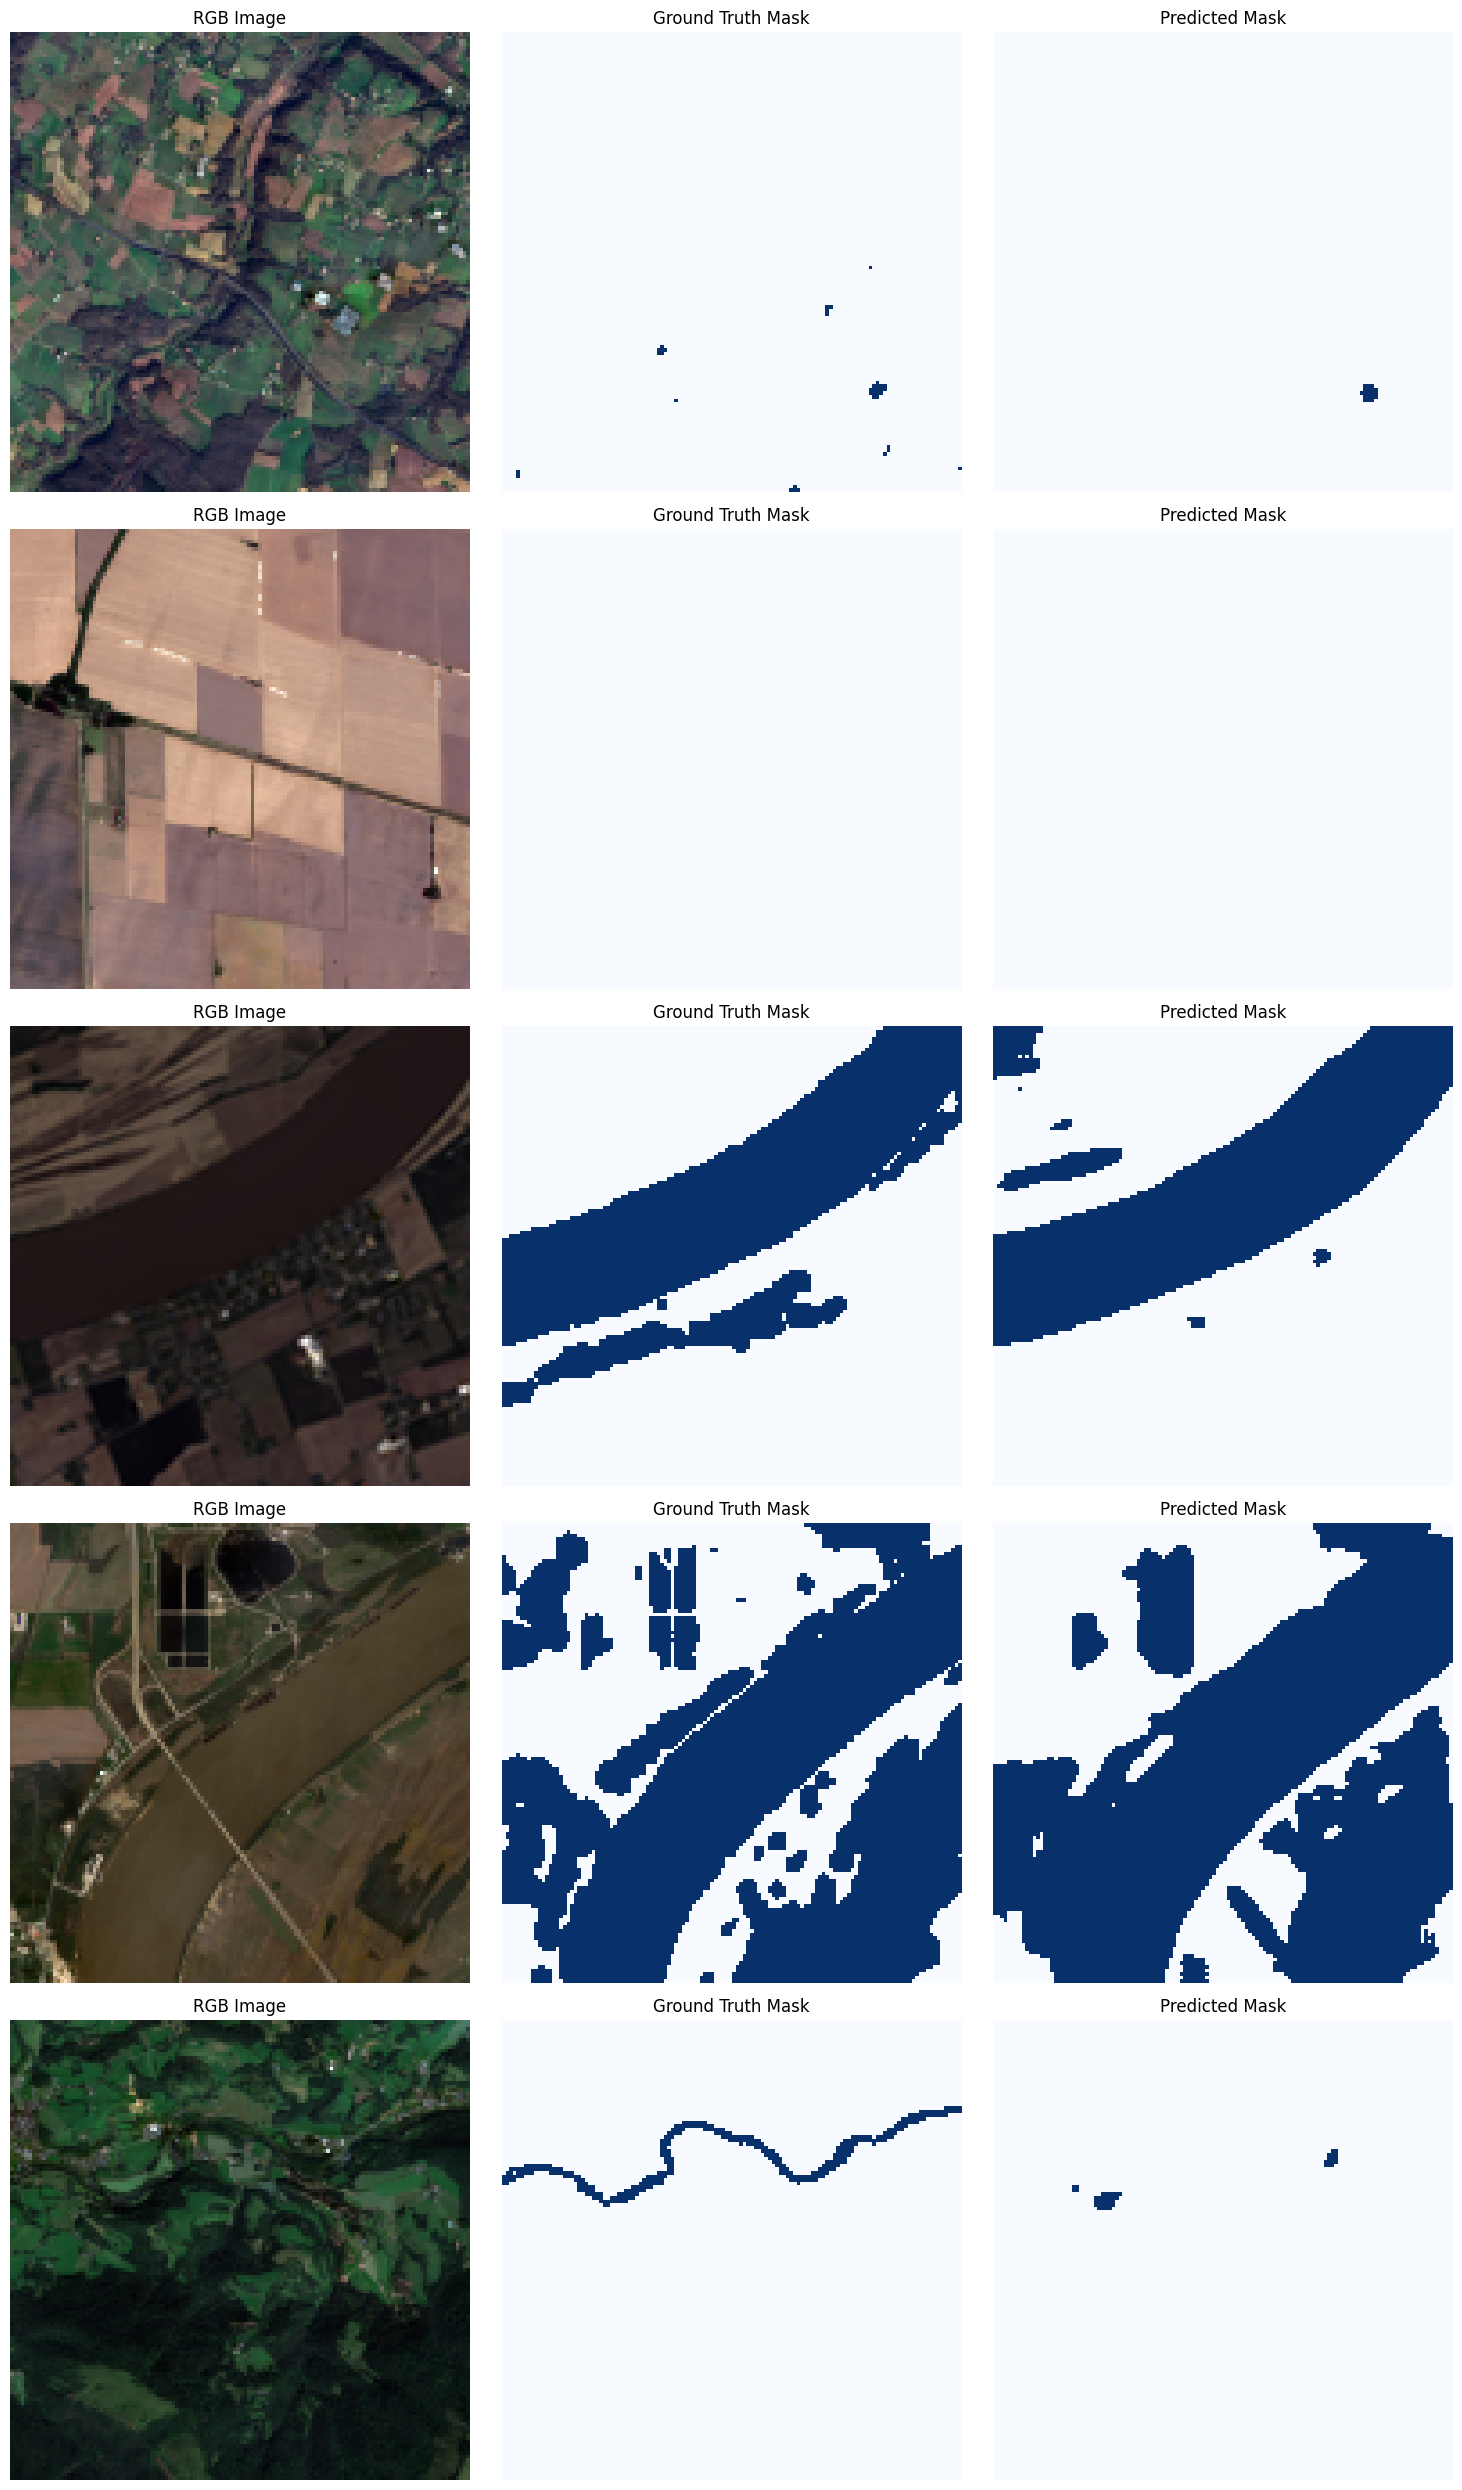

In [23]:
preds, masks = test_model(model, test_loader)

sample_images = [test_dataset[i][0].numpy() for i in range(5)]
visualize_results(sample_images, masks[:5], preds[:5], n=5)

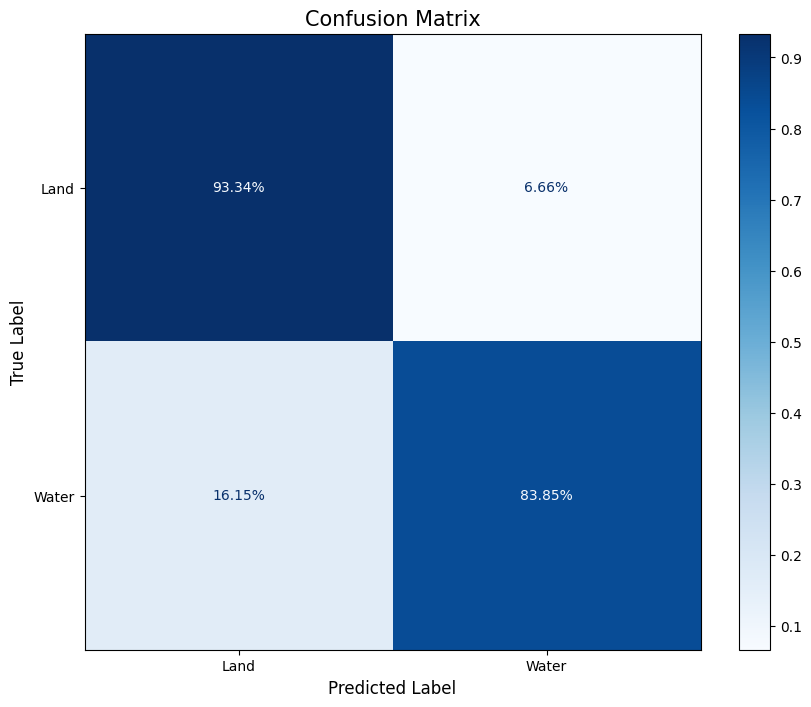

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(masks, preds):
    all_masks = np.array(masks).flatten()
    all_preds = np.array(preds).flatten()
        
    cm_norm = confusion_matrix(all_masks, all_preds, normalize='true')
    
    fig, ax = plt.subplots(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=['Land', 'Water'])
    
    disp.plot(cmap='Blues', ax=ax, values_format='.2%')
    
    plt.title('Confusion Matrix', fontsize=15)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.show()

plot_confusion_matrix(masks, preds)